### This notebook looks at the communicability within and across ntwx with and without SC lesions 

#### The code for communicability, navigation, shortest path are courtesy of Caio Seguin and the Brain Connectivity Toolbox. 
#### They were originally written in Matlab and translated to python by Chat-GPT. 
#### All these functions exist in a script called `communicability_functions.py`
#### See this link for the orginal Matlab versions of the functions (the functions are in the `fcn` folder): https://github.com/brain-networks/local_scfc/tree/main

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be done as an average for 200 subjects.
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
from collections import Counter

In [5]:
import pickle

In [87]:
from communicability_functions import navigate

In [5]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [6]:
import re

In [7]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [8]:
Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

In [9]:
def load_wts(sub_id):

    _df = pd.read_csv(Wts_Path + '/{0}/{0}_new_atlas_Yeo.nii.csv'.format(sub_id), delimiter=' ',header=None)
    df_trimmed = _df.iloc[:-31, :-31]
    np_array = df_trimmed.values
    sc_mtx = np_array + np_array.T # --> Symmetric

    pre_laplachian_HCP_SC = sc_mtx.copy()

    SC = pre_laplachian_HCP_SC.copy()
    sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))
    
    return pre_laplachian_HCP_SC

In [10]:
%%time
all_subs_pre_lap_SC = []

for i in range(len(sub_list)):
    pre_lap_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)

CPU times: user 6.93 s, sys: 38.3 ms, total: 6.97 s
Wall time: 16.6 s


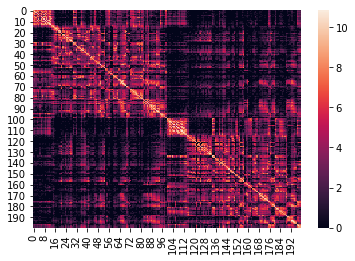

In [11]:
sns.heatmap(np.log1p(all_subs_pre_lap_SC[0]))

In [12]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [13]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [14]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 59 s, sys: 392 ms, total: 59.4 s
Wall time: 1min 17s


In [15]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.39 s, sys: 79.3 ms, total: 1.47 s
Wall time: 1.48 s


In [16]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [17]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [18]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
# all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
# all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
# all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
# all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
# all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
# all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
# all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
#     all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
#     all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
#     all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
#     all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
#     all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
#     all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
#     all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 1min 21s, sys: 2.42 s, total: 1min 24s
Wall time: 3min


In [19]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

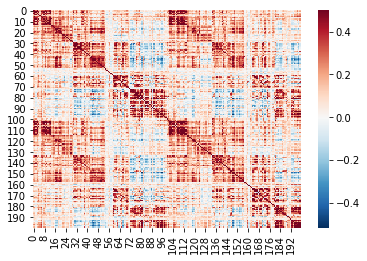

In [20]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

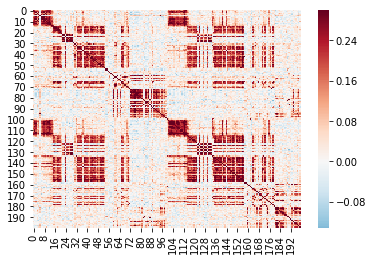

In [21]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [22]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [23]:
# corrs_list

In [24]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [25]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

###  get the distance mtx

In [26]:
# from Davide's OHBM 2023 educational course google colab: 
# https://colab.research.google.com/drive/10irtJ_htqaicwL5r3DJOxu1vfQpAyYbK#scrollTo=AYDc8nuQAIjq

In [27]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
    for roi2 in range(coords.shape[0]):
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




--> `distance` is distance mtx

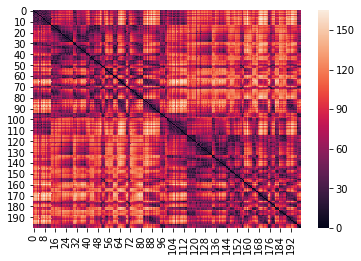

In [28]:
sns.heatmap(distance)

## Get Components

In [31]:
# intact sc

# """
#     GET_COMPONENTS - connected components

#     [comps, comp_sizes] = get_components(adj)

#     Returns the components of an undirected graph specified by the binary and
#     undirected adjacency matrix adj. Components and their constituent nodes are
#     assigned the same index and stored in the vector, comps. The vector, comp_sizes,
#     contains the number of nodes belonging to each component.

#     Inputs:
#         adj - binary and undirected adjacency matrix

#     Outputs:
#         comps - vector of component assignments for each node
#         comp_sizes - vector of component sizes
# """

In [91]:
def navigate2(C, MS, max_hops=None):
    if max_hops is None:
        max_hops = C.shape[0]
    n = C.shape[0]
    nav = {
        'inputs': {
            'C': C,
            'MS': MS,
            'max_hops': max_hops
        },
        'paths': [[None] * n for _ in range(n)],
        'num_hops': np.zeros((n, n), dtype=int),
        'pl_MS': np.zeros((n, n)),
        'failed_paths': np.zeros((n, n), dtype=int)
    }
    np.fill_diagonal(nav['failed_paths'], 1)
    
    for i in range(n):
        for j in range(n):
            if i != j:

                curr_node = i
                last_node = curr_node
                target = j
                num_hops = 0
                pl_MS = 0
                nav['paths'][i][j] = [curr_node]

                while curr_node != target:

                    neighbors = np.where(C[curr_node, :] != 0)[0]
                    min_index = np.argmin(MS[target, neighbors])
                    next_node = neighbors[min_index]

                    if next_node is None or next_node == last_node or num_hops > max_hops:
                        num_hops = 0
                        pl_MS = 0
                        nav['failed_paths'][i, j] = 1
                        break

                    nav['paths'][i][j].append(next_node)
                    num_hops += 1
                    pl_MS += MS[curr_node, next_node]

                    last_node = curr_node
                    curr_node = next_node

                nav['num_hops'][i, j] = num_hops
                nav['pl_MS'][i, j] = pl_MS

    return nav

In [92]:
test_sc_mtx = all_subs_pre_lap_SC[0].copy()

In [93]:
test_nav = navigate2(test_sc_mtx, distance)

In [94]:
test_nav

{'inputs': {'C': array([[ 6948,  3809,   535, ...,    10,     7,     6],
         [ 3809, 27742,  2447, ...,    28,    15,    13],
         [  535,  2447, 10962, ...,    14,     6,     7],
         ...,
         [   10,    28,    14, ..., 11732,  4734,   901],
         [    7,    15,     6, ...,  4734, 31182,  5152],
         [    6,    13,     7, ...,   901,  5152,  6826]]),
  'MS': array([[ 0.        , 24.41311123, 27.27636339, ..., 43.26661531,
          50.35871325, 61.90315016],
         [24.41311123,  0.        , 22.36067977, ..., 52.95280918,
          62.12889827, 69.19537557],
         [27.27636339, 22.36067977,  0.        , ..., 64.06246951,
          68.05879811, 74.51174404],
         ...,
         [43.26661531, 52.95280918, 64.06246951, ...,  0.        ,
          18.11077028, 30.85449724],
         [50.35871325, 62.12889827, 68.05879811, ..., 18.11077028,
           0.        , 17.20465053],
         [61.90315016, 69.19537557, 74.51174404, ..., 30.85449724,
          17.2

In [115]:
test_nav['paths'][0]

[None,
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 12],
 [0, 13],
 [0, 14],
 [0, 15],
 [0, 16],
 [0, 14, 17],
 [0, 15, 18],
 [0, 42, 19],
 [0, 20],
 [0, 97, 21],
 [0, 22],
 [0, 22, 23],
 [0, 24],
 [0, 29, 25],
 [0, 26],
 [0, 29, 27],
 [0, 28],
 [0, 29],
 [0, 30],
 [0, 31],
 [0, 32],
 [0, 22, 33],
 [0, 22, 34],
 [0, 35],
 [0, 36],
 [0, 37],
 [0, 38],
 [0, 39],
 [0, 69, 40],
 [0, 94, 41],
 [0, 42],
 [0, 43],
 [0, 43, 44],
 [0, 60, 45],
 [0, 46],
 [0, 86, 47],
 [0, 46, 48],
 [0, 86, 49],
 [0, 50],
 [0, 51],
 [0, 52],
 [0, 157, 53],
 [0, 54],
 [0, 55],
 [0, 56],
 [0, 57],
 [0, 58],
 [0, 59],
 [0, 60],
 [0, 61],
 [0, 60, 62],
 [0, 63],
 [0, 64],
 [0, 65],
 [0, 66],
 [0, 67],
 [0, 68],
 [0, 69],
 [0, 70],
 [0, 71],
 [0, 72],
 [0, 73],
 [0, 74],
 [0, 75],
 [0, 76],
 [0, 77],
 [0, 78],
 [0, 79],
 [0, 80],
 [0, 81],
 [0, 82],
 [0, 83],
 [0, 84],
 [0, 85],
 [0, 86],
 [0, 87],
 [0, 88],
 [0, 89],
 [0, 90],
 [0, 91],
 [0, 92],
 [0, 93],

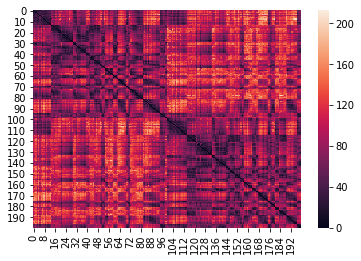

In [106]:
# sns.heatmap(test_nav['pl_MS'])

#### Code breakdown ...

In [53]:
C = test_sc_mtx.copy()
MS = distance.copy()

In [55]:
max_hops = C.shape[0]

In [79]:
n = C.shape[0]
nav = {
    'inputs': {
        'C': C,
        'MS': MS,
        'max_hops': max_hops
    },
    'paths': [[None] * n for _ in range(n)],
    'num_hops': np.zeros((n, n), dtype=int),
    'pl_MS': np.zeros((n, n)),
    'failed_paths': np.zeros((n, n), dtype=int)
}
np.fill_diagonal(nav['failed_paths'], 1)


In [81]:
print(nav['paths'][0][1])

None


In [82]:
temp_i  = 0
temp_j = 1

In [83]:
curr_node = temp_i
last_node = curr_node
target = temp_j
num_hops = 0
pl_MS = 0

In [84]:
nav['paths'][0][1] = curr_node

TypeError: list indices must be integers or slices, not tuple

In [70]:
curr_node

0

In [85]:
nav['paths'][0][1] = curr_node

In [86]:
print(nav['paths'][0][1])

0


In [ ]:
for i in range(n):
    for j in range(n):
        if i != j:

            curr_node = i
            last_node = curr_node
            target = j
            num_hops = 0
            pl_MS = 0
            nav['paths'][i, j] = [curr_node]

            while curr_node != target:

                neighbors = np.where(C[curr_node, :] != 0)[0]
                min_index = np.argmin(MS[target, neighbors])
                next_node = neighbors[min_index]

                if next_node is None or next_node == last_node or num_hops > max_hops:
                    num_hops = 0
                    pl_MS = 0
                    nav['failed_paths'][i, j] = 1
                    break

                nav['paths'][i, j].append(next_node)
                num_hops += 1
                pl_MS += MS[curr_node, next_node]

                last_node = curr_node
                curr_node = next_node

            nav['num_hops'][i, j] = num_hops
            nav['pl_MS'][i, j] = pl_MS

    return nav